In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append('../..')
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import xgboost as xgb
import shap
from scipy.stats import rankdata
from utils.general import L_U_to_CI
from utils.feature_importance import get_shap_global
from utils.feature_ranking import confident_simultaneous_ranking, calc_t_test
from experiments.real_data.preprocess_data import get_data_by_name
sns.set_theme(style='whitegrid')

In [2]:
# Set all fonts' sizes
params = {'legend.fontsize': 32,
          'legend.title_fontsize': 32,
          'axes.labelsize': 36,
          'axes.titlesize':40,
          'xtick.labelsize':32,
          'ytick.labelsize':32, 
          'lines.linewidth': 4, 
          'figure.titlesize': 40}
pylab.rcParams.update(params)

# Avoid Type 3 fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
name = 'nomao'
filepath = 'data/nomao.arff'
out_path = r'../../figures/real_data/nomao/'

data, target_name = get_data_by_name(name, filepath)

In [4]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V110,V111,V112,V113,V114,V115,V116,V117,V118,Class
0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,2,2,0.860946,0.82159,...,0.750000,0.500000,2,0.999953,0.777778,0.461538,2,1.0,1.000000,1
1,1.0,0.75,0.857143,0.857143,0.894737,0.947368,2,1,0.860946,0.82159,...,0.500000,0.307692,2,0.999983,0.538462,0.437500,2,1.0,1.000000,1
2,1.0,1.00,1.000000,1.000000,1.000000,1.000000,2,2,0.860946,0.82159,...,0.666667,0.461538,2,0.999993,0.800000,0.666667,2,1.0,1.000000,1
3,1.0,0.75,0.857143,0.857143,0.842105,0.833333,2,1,1.000000,1.00000,...,0.500000,0.285714,2,0.998605,0.555556,0.384615,2,1.0,0.999994,1
4,0.0,0.00,0.250000,0.000000,0.250000,0.000000,1,1,0.860946,0.82159,...,0.607880,0.396168,1,0.982576,0.644336,0.438054,1,1.0,0.979322,1


In [5]:
data[target_name].value_counts()

1    24621
0     9844
Name: Class, dtype: int64

In [6]:
feature_names = data.columns.drop(target_name)
# Split data
train, test = train_test_split(data, test_size=0.4, random_state=2)

X_train = train.drop(target_name, axis=1).reset_index(drop=True)
X_test = test.drop(target_name, axis=1).reset_index(drop=True)

Y_train = train[target_name].values
Y_test = test[target_name].values

print('train:', X_train.shape)
print('test:', X_test.shape)

train: (20679, 118)
test: (13786, 118)


In [7]:
model = xgb.XGBClassifier(random_state=2023, use_label_encoder=False,
                          objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.9978238792978383
0.9709125199477731


In [8]:
explainer = shap.TreeExplainer(model)

In [9]:
shap_means, shap_means_std, shap_values = get_shap_global(explainer, test[feature_names], return_local=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [10]:
base_importance = pd.DataFrame(np.abs(shap_values), columns=feature_names)
base_importance.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118
0,1.213304,0.045300,0.854290,0.679473,0.306498,1.951627,0.0,0.0,0.001405,0.147378,...,0.003618,0.348661,0.087314,0.001310,0.043228,0.140803,0.051440,0.0,0.015394,0.131253
1,0.513451,0.160755,0.472018,0.381747,0.141457,2.163528,0.0,0.0,0.000023,0.087016,...,0.037607,0.035930,0.050742,0.000383,0.033810,0.062091,0.001490,0.0,0.097930,0.003215
2,0.672888,0.107793,0.576013,0.287245,0.093755,1.656770,0.0,0.0,0.003053,0.052318,...,0.045096,0.142733,0.063354,0.000568,0.146244,0.051462,0.008503,0.0,0.015089,0.218709
3,1.395022,0.176007,0.365366,0.124296,0.338080,0.538186,0.0,0.0,0.000539,0.055333,...,0.060454,0.007589,0.004101,0.000640,0.079011,0.019508,0.014218,0.0,0.562963,0.013418
4,1.217166,0.008512,0.929161,1.203227,0.082345,1.648122,0.0,0.0,0.002517,0.049566,...,0.008811,0.008454,0.014878,0.001476,0.076279,0.034348,0.014706,0.0,0.000562,0.072464


In [11]:
holm_rank = confident_simultaneous_ranking(base_importance.values, 
                                           alpha=0.1, method='holm', paired_test_func=calc_t_test)
holm_rank['CI_len'] = holm_rank['U'] - holm_rank['L'] + 1

In [12]:
min_p_rank = confident_simultaneous_ranking(base_importance.values, 0.1, 'min_p', rep_bootstrap=2500)
min_p_rank['CI_len'] = min_p_rank['U'] - min_p_rank['L'] + 1

In [13]:
CI_len = pd.DataFrame()
CI_len['Holm'] = holm_rank['CI_len']
CI_len['Min-P'] = min_p_rank['CI_len']

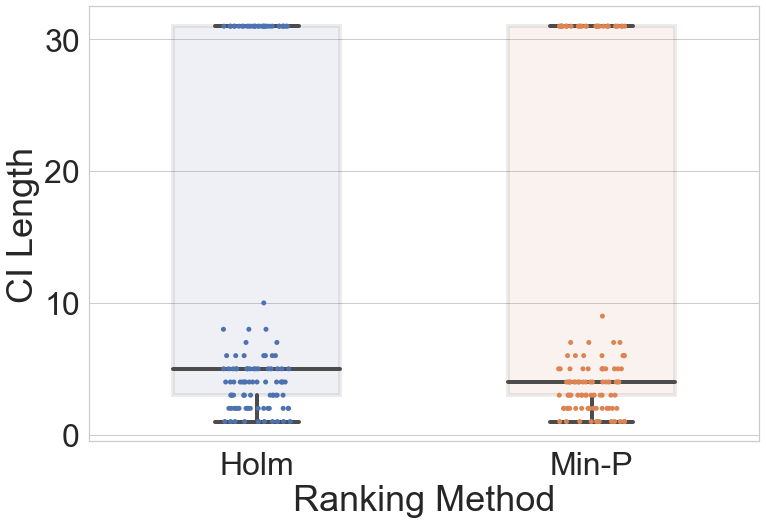

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
CI_len_long = CI_len.stack().reset_index().drop('level_0', axis=1)
CI_len_long.columns = ['Ranking Method', 'CI Length']
sns.boxplot(data=CI_len_long, x='Ranking Method', y='CI Length', boxprops={'alpha': 0.1}, width=.5, ax=ax)
sns.stripplot(data=CI_len_long, x='Ranking Method', y='CI Length', dodge=True, ax=ax)
ax.set_xlabel('Ranking Method');

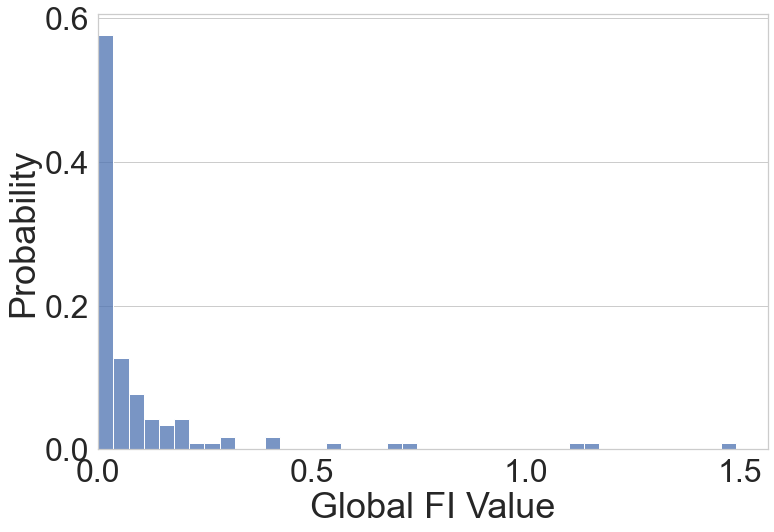

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=shap_means, stat='probability', ax=ax)
ax.set_xlabel('Global FI Value');
ax.set_xlim(0)
ax.grid(False, axis='x')
fig.savefig(out_path + 'FI_dist.pdf', bbox_inches='tight');

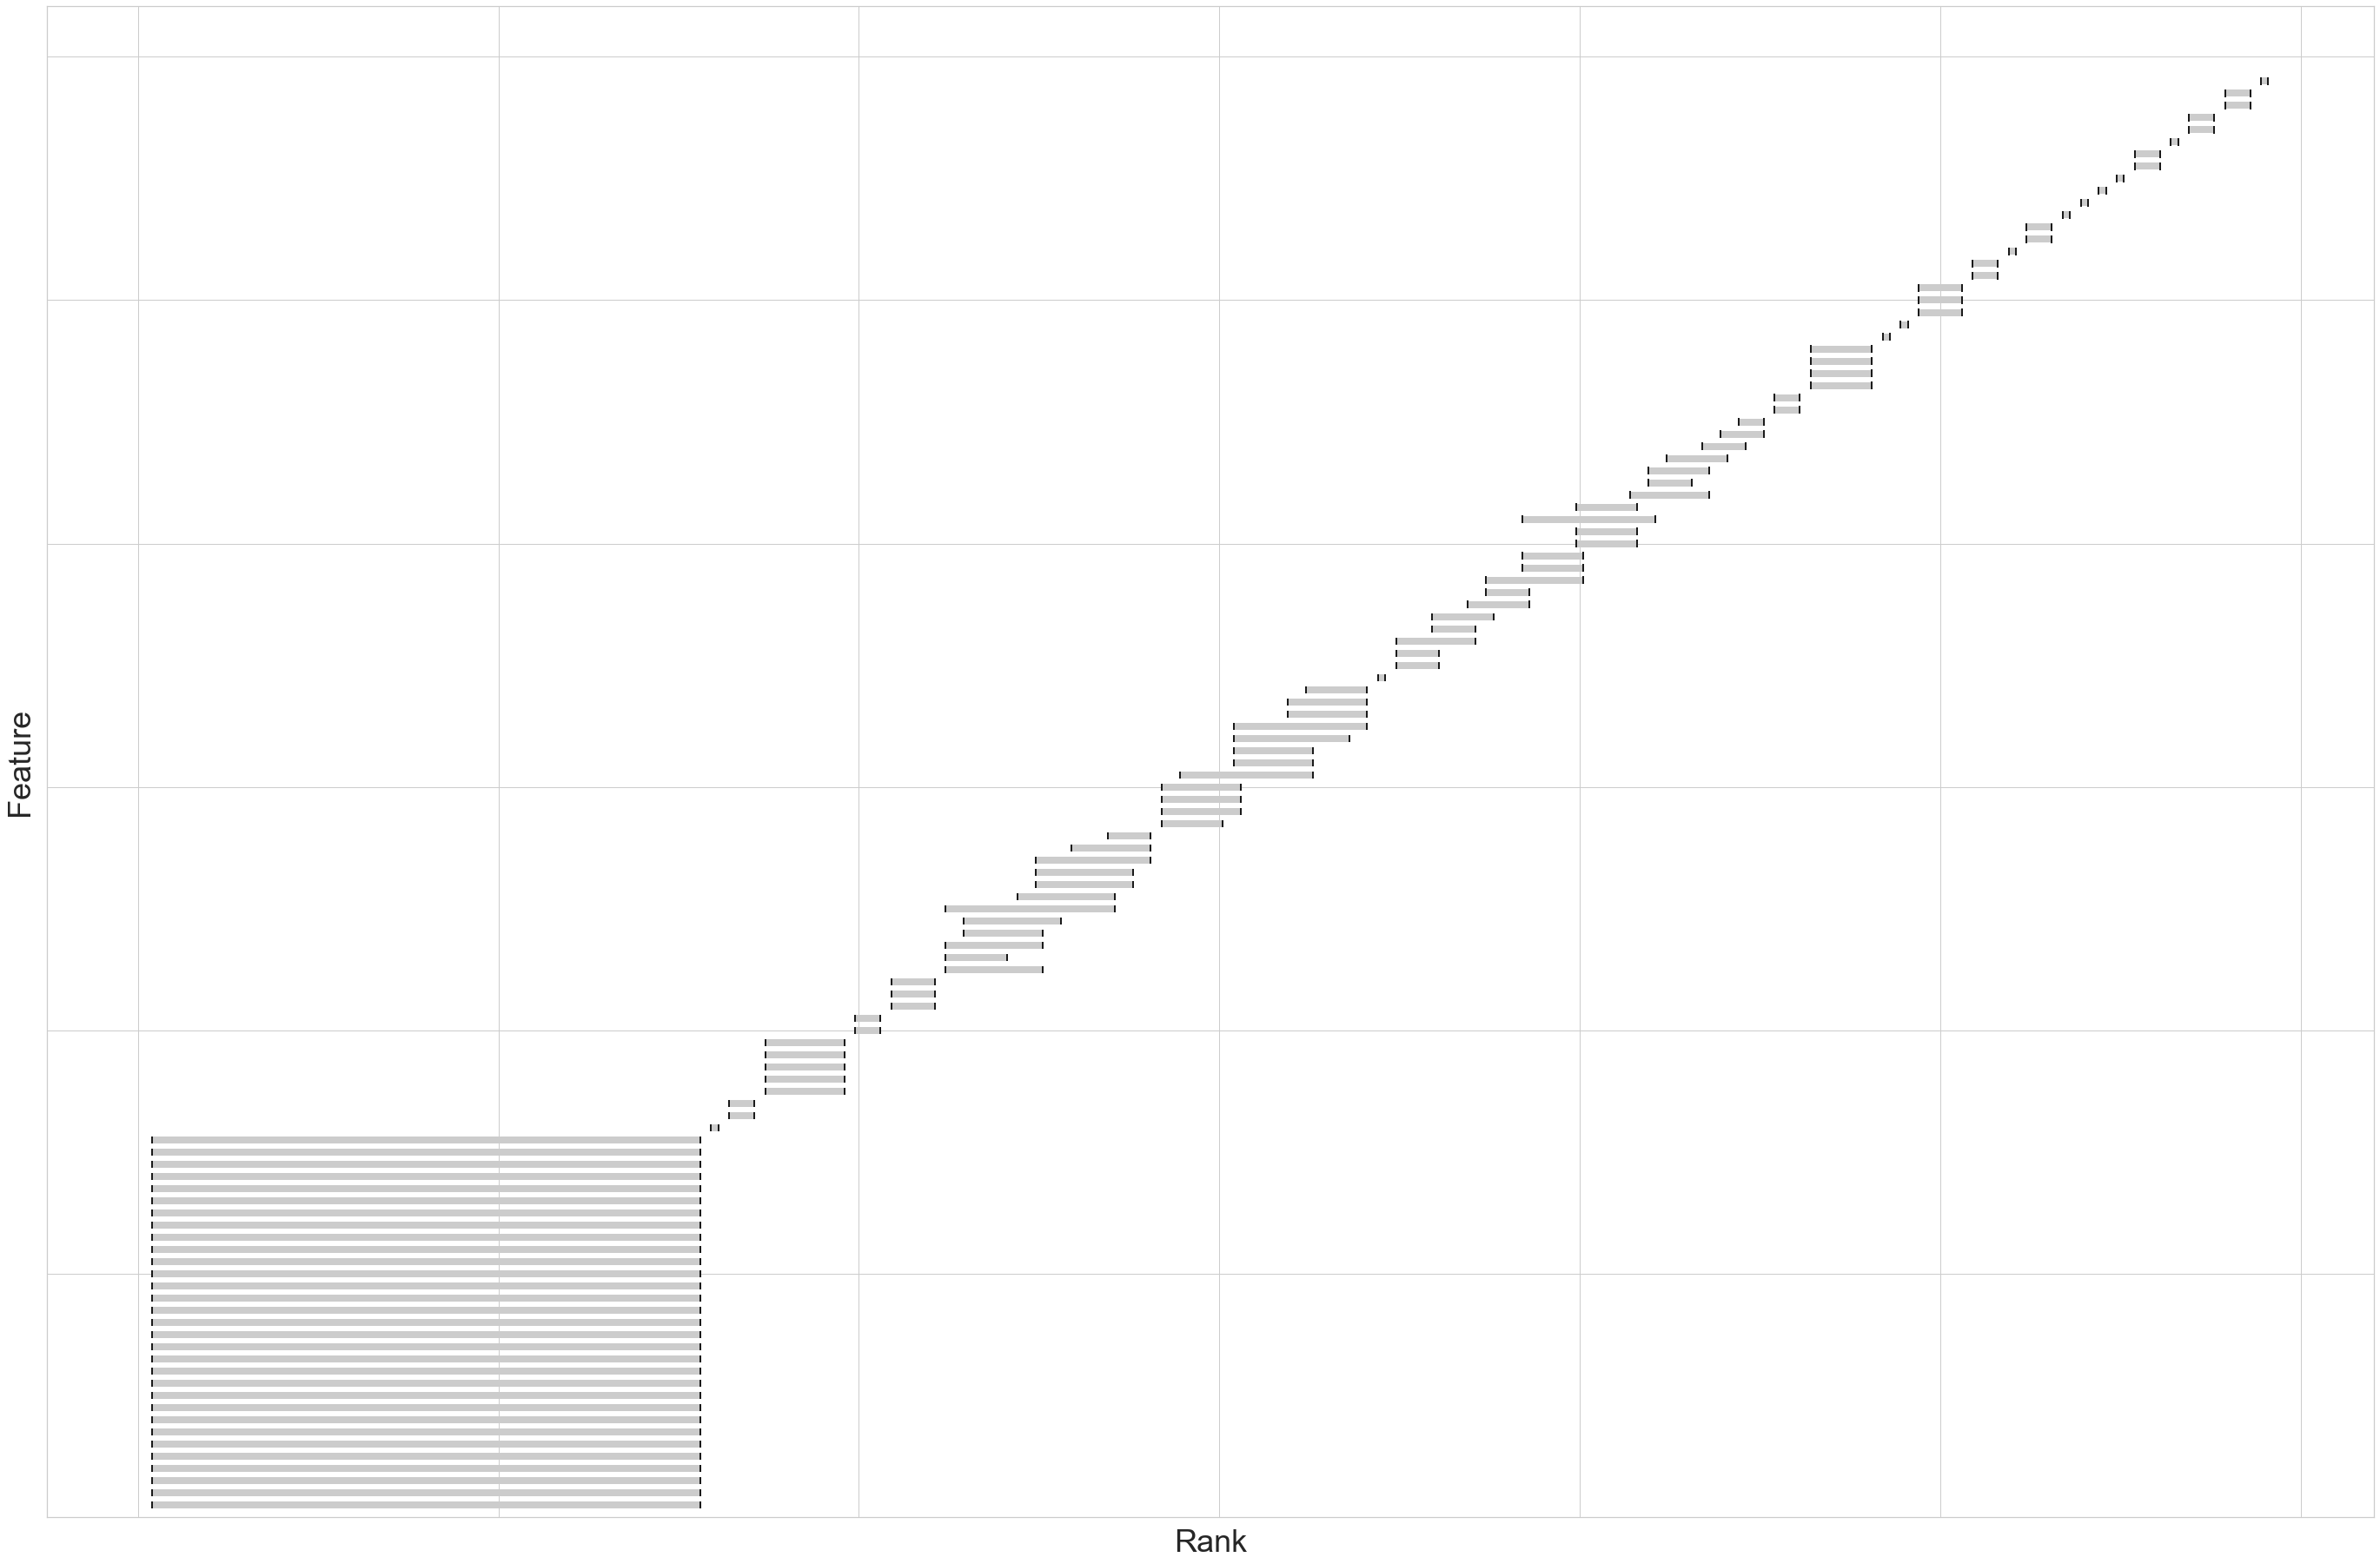

In [16]:
fig, ax = plt.subplots(figsize=(48, 32))
delta = 0.2
ranks_plot = pd.DataFrame()
ranks_plot['feature'] = feature_names
ranks_plot['globals_order'] = (rankdata(shap_means)).astype(int)
ranks_plot['CI'] = L_U_to_CI(holm_rank[['L', 'U']])
ranks_plot.loc[ranks_plot['globals_order'] == 16, 'globals_order'] = range(1, 32)
ranks_plot = ranks_plot.sort_values(by='globals_order', ignore_index=True)
for i, row in ranks_plot.iterrows():
    ax.hlines(y=row['globals_order'], xmin=row['CI'][0] - delta, xmax=row['CI'][1] + delta, 
                linewidths=8, colors=(0.8, 0.8, 0.8))
    ax.errorbar(row['CI'][0] - delta, row['globals_order'], yerr=0.3, ecolor='k', elinewidth=2)
    ax.errorbar(row['CI'][1] + delta, row['globals_order'], yerr=0.3, ecolor='k', elinewidth=2)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Rank')
ax.set_ylabel('Feature')
ax.set_ylim(0);